Van Gestel's Simulation Model
=====


#####Version 0.0.1
Here is the main part of *Simulation Model for Van Gestel Model in Simpy*

#### Explaination of codes 
I will just explain the main part of the codes. 
Here, we do a bunch of imports to set the project going 

In [34]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 20 01:19:20 2015

@author: Martin Nguyen
"""

from __future__ import division
import simpy
import copy
import csv
from numpy import random
from DoctorClass import Doctor
from MonitorClass import Monitor
monitor = Monitor (3000)
initiallist = []
onelist = [[0 for j in range(0)] for i in range(3000)]
twolist = [[0 for j in range(0)] for i in range(3000)]
list_IOP = []
list_MD = []
list_MDR = []
list_Age = []

In [35]:
class Patient(object):
    def __init__(self,env,name,Attribute):
        random.seed = 123
        self.name = name
        self.age = random.normal(68,5)
        self.env = env
        self.Attribute = Attribute
        self.params = {'IOPReduction':0,'time_next_visit': 0,'FirstProgression':0,'SecondProgression':0,'VFCountdown':0,
                       'SideEffect':0 }
        self.medicalRecords = {'PatientVisits': 0, 'MedicationIntake': 0,'MedicationCombination':[0,0,0,0,0],
                               'MedicationAmount': [0,0,0,0,0],'CurrentMedicationType':0,'TreatmentOverallStatus': 0,
                               'TreatmentBlock':1, 'MedicationPath': [0,0,0,0,0],'ContinueTreatment':True,
                               'NumberVF':0,
                               'NumberTrabeculectomy':0, 'TrabeculectomySuccess': True,
                               'OnTrabeculectomy': False}
        self.CostAttribute = {'QALY': 0, 'TotalCost': 0, 'Below-15': 0, 'ProductiveLoss':0}
        initiallist.append(copy.deepcopy(self.Attribute))
        monitor.UpdateInitial(self.Attribute)
        self.action = env.process(self.runSimulation())
    def params_update(self):
        if self.Attribute['IOP'] > 13:
            difference = self.Attribute['MDR'] *(1.13**(self.Attribute['IOP'] - 15.5))*(self.params['time_next_visit'])
        else:
            difference = 0
        # adjust with the time 
        self.Attribute['CumulativeMDR'] = self.Attribute['CumulativeMDR'] + difference
        self.Attribute['MD'] = self.Attribute['MD'] - difference
        self.Attribute['Age'] = self.Attribute['Age'] + self.params['time_next_visit']/12
        if  self.medicalRecords['ContinueTreatment'] == False or self.params['IOPReduction'] < 0.001:
            self.onNoMedicationOrTrabeculectomy()
        if self.medicalRecords['ContinueTreatment'] == True and self.medicalRecords['TreatmentBlock'] <> 0:
            self.onMedication()
        if self.medicalRecords['CurrentMedicationType'] == 10 or self.medicalRecords['CurrentMedicationType'] == 5 and self.params['IOPReduction'] > 0:
            self.params['IOPReduction'] -= self.params['IOPReduction']*(self.params['time_next_visit']/12)
    def UpdateMedicationCombination(self):
        if self.medicalRecords['MedicationCombination'][0] == 1:
            monitor.Medication1Update(self.name,self.params['time_next_visit'])
        if self.medicalRecords['MedicationCombination'][1] == 1:
            monitor.Medication2Update(self.name,self.params['time_next_visit'])
        if self.medicalRecords['MedicationCombination'][2] == 1:
            monitor.Medication2Update(self.name,self.params['time_next_visit'])
        if self.medicalRecords['MedicationCombination'][3] == 1:
            monitor.Medication3Update(self.name,self.params['time_next_visit'])
        if self.medicalRecords['MedicationCombination'][4] == 1:
            monitor.Medication5Update(self.name,self.params['time_next_visit'])
    def onNoMedicationOrTrabeculectomy(self):
        self.params['SideEffect'] = 0
            #IOP is supposed to increase 0.5% annually, without medication
        if  self.medicalRecords['OnTrabeculectomy'] == True:
            self.Attribute['IOP'] = self.Attribute['IOP'] *(1 + (2/100)*(self.params['time_next_visit']/12))
        else:
            self.Attribute['IOP'] = self.Attribute['IOP'] *(1 + (0.5/100)*(self.params['time_next_visit']/12))
    def onMedication(self):
        self.medicalRecords['MedicationIntake'] = self.medicalRecords['MedicationIntake'] +1 
        self.Attribute['IOP'] = self.Attribute['IOP'] *(1-self.params['IOPReduction']*(self.params['time_next_visit']/12))
        self.UpdateMedicationCombination()
    def inCurredSideEffect(self,doctor):
        SideEffect = 0            
        if random.uniform(0,1) < self.params['SideEffect']:
            self.medicalRecords['TreatmentOverallStatus'] = 1
            self.medicalRecords['ContinueTreatment'] = True
            doctor.DoctorModule() 
            SideEffect = 1
        self.CostAttribute['QALY'] += (0.94 - 0.097*SideEffect + 0.015*self.Attribute['MD'] - 0.092*0.4)*(self.params['time_next_visit']/12)
    def  runSimulation (self):
        while True:
            doctor = Doctor(self.Attribute,self.params,self.medicalRecords)
            doctor.ReturnAllDoctorValues()
            self.inCurredSideEffect(doctor)
            monitor.CumulativeCostfromMD(self.name,self.Attribute['MD'],self.Attribute['Age'],self.params['time_next_visit'])
            yield self.env.timeout(self.params['time_next_visit'])
            self.params_update()
            onelist[self.name].append(self.Attribute['IOP'])
            twolist[self.name].append(self.Attribute['MD'])
            del doctor

In [36]:
def csv_dict_reader(file_obj):
    reader = csv.DictReader(file_obj, delimiter=',')
    for line in reader:
        list_IOP.append(float(line["IOP"]))
        list_MD.append(float(line["MD"]))
        list_MDR.append(float(line["MDR"]))
        list_Age.append(float(line["Age"]))

def final_cost_calculate(patientlist):
    i = 0
    for obj in patientlist:
        obj.CostAttribute['TotalCost'] += (obj.medicalRecords['NumberTrabeculectomy'] * 1214 + obj.medicalRecords['PatientVisits'] * (6+2+65))
        obj.CostAttribute['TotalCost'] += (obj.CostAttribute['Below-15']*325 + obj.CostAttribute['ProductiveLoss']*3029)  
        obj.CostAttribute['TotalCost'] += (obj.medicalRecords['NumberVF'] *150)
        monitor.finalCostPatient(i,obj.medicalRecords['NumberTrabeculectomy'],obj.medicalRecords['PatientVisits'],obj.medicalRecords['NumberVF'])
        i += 1

In [37]:
if __name__ == "__main__":
    patientlist = []
    alllist = [] 
    field_names = "IOP,MD,MDR,Age".split(",")
    path = "Patients_list.csv"
    with open("Patients_list.csv") as f_obj:
        csv_dict_reader(f_obj)
    env = simpy.Environment()   
    
    for i in range(3000):
        patientlist.append( Patient(env,i,{'IOP':list_IOP[i],'MD': list_MD[i],'MDR':list_MDR[i],'CumulativeMDR': 0,'IOPTarget': 24,'Age':list_Age[i], 'TrabeculectomyIOP': 0}))
    env.run(until = 200)
    final_cost_calculate (patientlist)


In [44]:
newlist = []
newlist1 = []
#for obj in monitor.initiallist:
#    newlist1.append(obj['MD'])
sum4 = 0
for obj in monitor.TotalCost:
    sum4 += obj
sum1 = 0
sum3 = 0
for obj in patientlist:
    newlist.append(obj.Attribute['MD'])
    newlist1.append(obj.medicalRecords['CurrentMedicationType'])
    sum1 += obj.CostAttribute['QALY']
    sum3 += obj.Attribute['MD']



print ('Average Quality-of-Life-Years of simulated patients: {}'.format( sum1/3000))
print ('Average final MD values: {}'.format(sum3/3000))
print ('Average final medical costs: {}'.format( sum4/3000))


Average Quality-of-Life-Years of simulated patients: 12.7145455191
Average final MD values: -12.2762622821
Average final medical costs: 30309.0198007


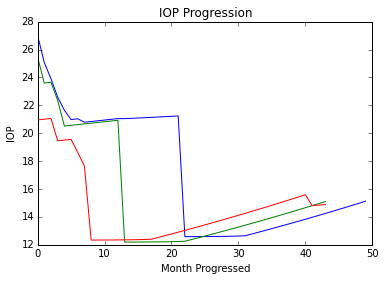

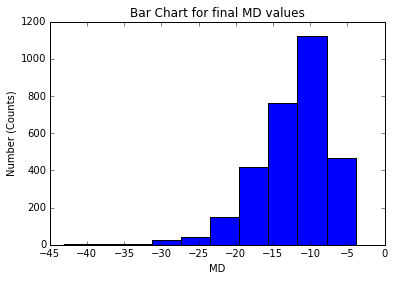

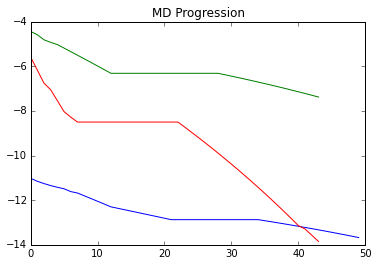

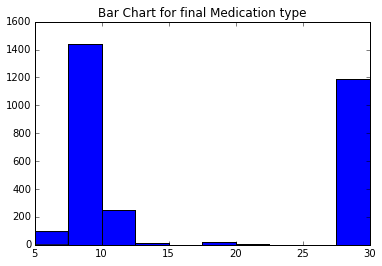

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
#plot the time series
###########
plt.figure(1)
for i in range(3):
    plt.plot(onelist[i])
plt.title("IOP Progression")
plt.xlabel("Month Progressed")
plt.ylabel("IOP")
############
plt.figure(2)
plt.hist(newlist)
plt.title("Bar Chart for final MD values")
plt.xlabel("MD")
plt.ylabel("Number (Counts)")
############
plt.figure(3)
for i in range(3):
    plt.plot(twolist[i])
plt.title("MD Progression")
############
plt.figure(4)
plt.hist(newlist1)
plt.title("Bar Chart for final Medication type")